In [2]:
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd

### **Loading Data**

In [3]:
# This cell is necessary only if you are running on Google Colab. It downloads the files to your
# Colab instance so you don't have to upload them here.

import requests

def save_file(url, file_name):
    r = requests.get(url)
    with open(file_name, 'wb') as f:
      f.write(r.content)

save_file('https://courses.cs.washington.edu/courses/cse416/23sp/homeworks/hw5/edx_train.csv',
          'edx_train.csv')
save_file('https://courses.cs.washington.edu/courses/cse416/23sp/homeworks/hw5/edx_test.csv',
          'edx_test.csv')

In [4]:
target = "certified" # target column

# initialize train/test set
df_train = pd.read_csv('edx_train.csv')
df_test = pd.read_csv('edx_test.csv')

# **Classifier #1: Decision Tree**


#### **Part 1: Storing target data for later analysis**
Since I need the userId_DI column for evaluating results, but I do not want it as a feature, I need to store it elsewhere and preserve its order for later comparison to my model's predictions.

In [5]:
train_target = df_train['certified']

#### **Part 2: One-Hot Encoding**
First, I need to transform the categorical variables into numeric ones. Because not all of my variables are categorical, I will only use pd.get_dummies on a few:

select_dtypes will help me determine which variables are categorical, by storing all 'object' dtype columns in my 'cateogrical_cols_train' and 'categorical_cols_test'. The columns stored in these indexes will be one-hot encoded.

After converting these to binary numeric features, I will append them to my original df_train/test datasets. This will involve removing the "un-transformed" categorical columns from my original datasets before appending, to ensure no duplicates.

In [6]:
# Drop the target and user ID columns before one-hot encoding
df_train_no_target = df_train.drop(columns=['certified', 'userid_DI'])
df_test_no_user_id = df_test.drop(columns=['userid_DI'])

# Identify categorical columns (columns with 'object' dtype)
categorical_cols_train = df_train_no_target.select_dtypes(include=['object']).columns
categorical_cols_test = df_test_no_user_id.select_dtypes(include=['object']).columns

# Apply one-hot encoding to all categorical columns in the training and testing dataframes
transformed_data_train = pd.get_dummies(df_train_no_target, columns=categorical_cols_train)
transformed_data_test = pd.get_dummies(df_test_no_user_id, columns=categorical_cols_test)

# Add back the target column to the training data
student_data_train = transformed_data_train.copy()
student_data_train['certified'] = train_target

#### **Part 3: Fitting Model to Training Data / Setting Features**
Through trial and error I determined which combination of features yielded the highest training accuracy.

In [7]:
decision_tree_model = DecisionTreeClassifier(max_depth=6)

# Set features
features = ['gender_m',                                # gender, male (m) or female (f)
            'explored',                                # accessed at least half of course chapters (0 or 1)
            'course_id_HarvardX/CB22x/2013_Spring',    # enrolled in CB22x, Spring 2013 (0 or 1)
            'course_id_HarvardX/CS50x/2012',           # enrolled in CS50x, 2012 (0 or 1)
            'course_id_HarvardX/ER22x/2013_Spring',    # enrolled in ER22x, Spring 2013 (0 or 1)
            'course_id_HarvardX/PH207x/2012_Fall',     # enrolled in PH207x, Fall 2012 (0 or 1)
            'course_id_HarvardX/PH278x/2013_Spring',   # enrolled in PH278x, Spring 2013 (0 or 1)
            'nevents',                                 # total interactions with course content
            'ndays_act',                               # unique days student engaged with course
            'nchapters',                                # number of chapters interacted with
             ]

decision_tree_model.fit(student_data_train[features], train_target)

DecisionTreeClassifier(max_depth=6)

#### **Part 4: Visualizing the Tree**
Here, I took code from HW 3 to visualize what the tree looks like when we set max_depth to 2 (it would be difficult to visualize a deeper depth).

This visualization simply acts as a way for me to better understand how the model chooses variables, and even offers insight into which variables might carry more weight.

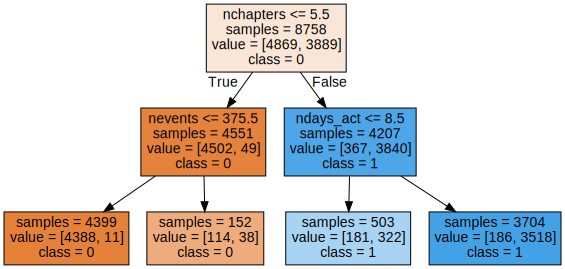

In [8]:
import graphviz
from sklearn import tree


def draw_tree(tree_model, features):
    """
    visualizes a Decision Tree
    """
    tree_data = tree.export_graphviz(tree_model,
                                    impurity=False,
                                    feature_names=features,
                                    class_names=tree_model.classes_.astype(str),
                                    filled=True,
                                    out_file=None)
    graph = graphviz.Source(tree_data)
    display(graph)

small_tree_model = DecisionTreeClassifier(max_depth=2, random_state=0)
small_tree_model.fit(student_data_train[features], train_target)
draw_tree(small_tree_model, features)

#### **Part 5: Accuracies**
Now it's time to make predictions! I'm using NumPy's mean function to determine the percentage of correct predictions my model makes.

Like I mentioned in part 3, my features list was constructed though trial and error; I constantly updating it based on the training accuracy.

What I found surprising, is that by replacing level of education (secondary, bachelors, masters, etc.) for couse_id, my training accuracy improved. Additionally, including course interaction variables such as nchapters, ndays_act, and nevents, caused my training accuracy to shoot up 5%, getting me a train accuracy of 97.5%.

In [9]:
train_predictions = decision_tree_model.predict(student_data_train[features])
decision_train_accuracy = np.mean(train_predictions == train_target)
print(decision_train_accuracy)

0.9757935601735556


####**Part 6: GridSearchCV**
To ensure the best hyperparameter settings for my model, I used GridSearchCV to cross validate between a few different options. This also gave me insight into choosing hyperparameters that consider the bias/variance tradeoff.

I did not test my model on a validation set earlier, and therefore had no clue how to choose hyperparameters based on unseen data - GridSearchCV helps me fill in the blanks.

In [10]:
from sklearn.model_selection import GridSearchCV

decision_tree_model2 = DecisionTreeClassifier()
hyperparameters = {
    'min_samples_leaf': [1, 10, 50, 100, 200, 300],
    'max_depth': [1, 5, 10, 15, 20]
}

search = GridSearchCV(decision_tree_model2, hyperparameters, cv=6, return_train_score=True)
search.fit(student_data_train[features], train_target)

GridSearchCV(cv=6, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 5, 10, 15, 20],
                         'min_samples_leaf': [1, 10, 50, 100, 200, 300]},
             return_train_score=True)

In [11]:
optimal_depth = search.best_params_['max_depth']
optimal_min_samples_leaf = search.best_params_['min_samples_leaf']

print(search.best_params_)

{'max_depth': 5, 'min_samples_leaf': 10}


#####**Visualizing Different Parameter Combinations**
Here, I've taken code from HW3 to get a look into how the different combinations of depth and minimum leaf nodes influence bias & variance.

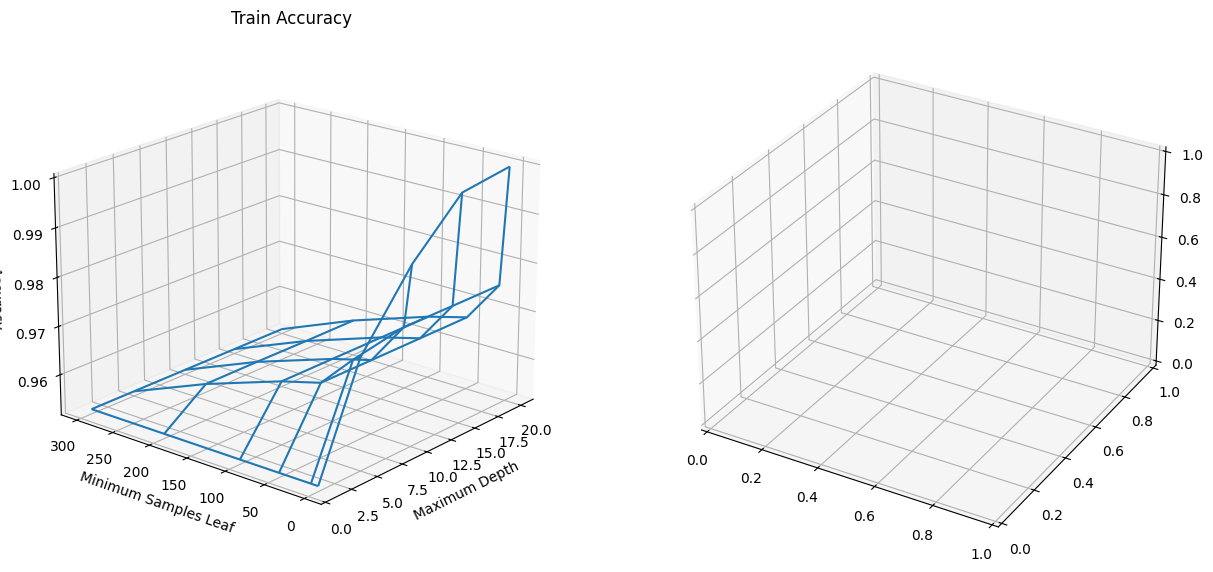

In [12]:
import matplotlib.pyplot as plt
def plot_scores(ax, title, search, hyperparameters, score_key):
    # Get results from GridSearch and turn scores into matrix
    cv_results = search.cv_results_
    scores = cv_results[score_key]
    scores = scores.reshape((len(hyperparameters['max_depth']), len(hyperparameters['min_samples_leaf'])))
    max_depths = cv_results['param_max_depth'].reshape(scores.shape).data.astype(int)
    min_samples_leafs = cv_results['param_min_samples_leaf'].reshape(scores.shape).data.astype(int)

    # Plot result
    ax.plot_wireframe(max_depths, min_samples_leafs, scores)
    ax.view_init(20, 220)
    ax.set_xlabel('Maximum Depth')
    ax.set_ylabel('Minimum Samples Leaf')
    ax.set_zlabel('Accuracy')
    ax.set_title(title)


fig = plt.figure(figsize=(15,7))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
plot_scores(ax1, 'Train Accuracy', search, hyperparameters, 'mean_train_score')

####**Part 7: Finalizing Classifier #1 (Decision Tree Model) - Adjusting Hyperparameters**
Based on my GridSearchCV, I found that my model performs best when max_depth = 5 and min_samples_leaf = 10. Therefore I will include these parameter specifications in my final Decision Tree model before I run it on my test set.

In [13]:
decision_tree_model.set_params(max_depth=optimal_depth, min_samples_leaf=optimal_min_samples_leaf)

decision_tree_model.fit(student_data_train[features], train_target)

tree_train_predictions = decision_tree_model.predict(student_data_train[features])

tree_train_accuracy = np.mean(tree_train_predictions == train_target)
print(tree_train_accuracy)

0.9739666590545787


####**Final Part: Testing Classifier #1 (Decision Tree Model) on Test Set**

In [14]:
test_predictions = decision_tree_model.predict(transformed_data_test[features])

to_save = df_test[['userid_DI']].copy()
to_save.loc[:, 'certified'] = test_predictions
to_save.to_csv('submission.csv', index=False)

##**Classifier 2: Logistic Regression Model**
This section is much shorter than the previous, considering that I've already set my features (which based on model performance, I don't want to change here) and onehot encoded the dataset.

####**Part 1: Creating a Random Forest Class**
Here, I am using sklearn's RandomForestClassifier to initialize the model.

In [15]:
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score

rf = RandomForestClassifier(n_estimators=10, max_depth=1, bootstrap=True, n_jobs=-1)
rf.fit(student_data_train[features], train_target)

rf_predictions = rf.predict(transformed_data_test[features])

rf_train_predictions = rf.predict(student_data_train[features])

rf_train_accuracy = accuracy_score(train_target, rf_train_predictions)

print(rf_train_accuracy)

0.9448504224708838


####**Part 2: Finding Optimal Hyper Parameters**
I will be using GridSearchCV once again to determine the optimal hyper parameters for my random forest classifier. Right now, the training accuracy is ~2% below my decision tree - let's see if I can change that.

In [16]:
from sklearn.model_selection import GridSearchCV

hyperparameters = {
    'n_estimators': [50, 100],  # Number of trees
    'max_depth': [None, 10],  # Maximum depth of each tree
    'min_samples_split': [2, 5],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2],  # Minimum samples per leaf
}

grid_search = GridSearchCV(
    rf,
    hyperparameters,
    cv=5,  # 5-fold cross-validation
    n_jobs=-1,  # Run in parallel
    verbose=2  # Shows progress
)

# Fit GridSearchCV on training data
grid_search.fit(student_data_train[features], train_target)

# Print the best hyperparameters
print("Best Hyperparameters:", grid_search.best_params_)

# Use the best model
best_rf = grid_search.best_estimator_

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


####**Part 3: Implementing Optimal Parameters**
Now lets plug in the optimal hyperparameters we found from GridSearchCV, into the classifier!

In [17]:
rf.set_params(max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100)

rf.fit(student_data_train[features], train_target)

rf_train_predictions = rf.predict(student_data_train[features])

rf_train_accuracy = np.mean(rf_train_predictions == train_target)
print(rf_train_accuracy)

0.9816168074902946


Woohoo! My random forest classifier scores an even better training accuracy than my decision tree classifier, at ~98.1% accuracy :D

####**Final Part: Testing Classifier #2 (Random Forest) on Test Data**

In [18]:
rf_test_predictions = rf.predict(transformed_data_test[features])


to_save = df_test[['userid_DI']].copy()
to_save.loc[:, 'certified'] = rf_test_predictions
to_save.to_csv('rf_submission.csv', index=False)

##**Comparing Models**
Here I provide a visualization for how my models perform differently on training data.

####**Confusion Matrix: Classifier #1 - Decision Tree**

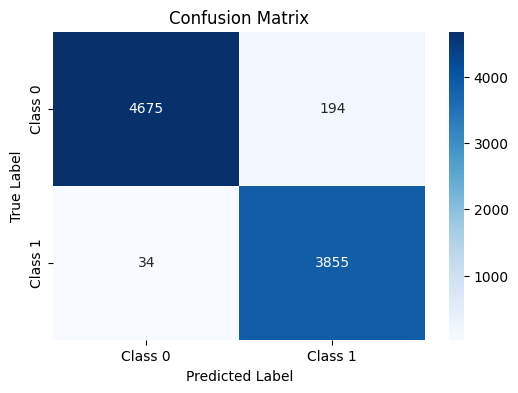

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

tree_cm = confusion_matrix(train_target, tree_train_predictions)

plt.figure(figsize=(6,4))
sns.heatmap(tree_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

####**Confusion Matrix: Classifier #2 - Random Forest**

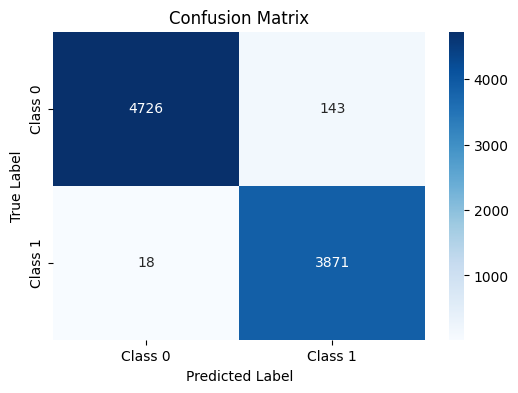

In [20]:
rf_cm = confusion_matrix(train_target, rf_train_predictions)

plt.figure(figsize=(6,4))
sns.heatmap(rf_cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### **Discussion**



**Classifier #1:**

For my decision tree model, I tried to be as efficient as possible by not messing around with parameters in the beginning steps of my training process. I wanted to establish my feature set first so that I could start my model off on good footing. After testing out different feature combinations, I went with the set that produced the best training accuracy.

Once I had my features set, I used GridSearchCV to find optimal hyperparameters for the depth of my tree and minimum leaf node samples. I drew from HW3 to decide which hyperparameter values to test out. Before this point I hadn't set any hyperparameters, hence when I implemented my findings from GridSearchCV, I saw significant improvement in my training accuracy. This approach worked well for me considering it offered a way to model build based on validation accuracy, and yielded good results.


**Classifier #2:**

For my random forest model, the model training process was quicker. I had already one-hot encoded my dataset and determined by feature set. I jumped straight to GridSearchCV for determining hyperparameters as to not waste time doing so manually.

Just as I did for my decision tree, I tested different combinations of max_depth and min_samples_leaf, with the addition of n_estimators for random forest. However for this classifier, I wanted to increase complexity a little bit more in hopes of reaching a higher training accuracy. Therefore I also included different values of min_samples_split in my GridSearchCV, to adjust the minimum samples required to split on internal nodes. This worked out well for me, and helped me boost my training accuracy by 1% to 98% training accuracy. I chose to submit this model to Kaggle for prediction on the private dataset.

####**What do we see in the visualizations?**
Both confusion matrices emphasize the superior predictive power of the random forest classifier on training data. While the decision tree classifier predicted 4,675 true negatives and 3,855 true positives, the random forest classifier exceeded both numbers - 53 more true negatives and 10 more true positives. Naturally, the decision tree classifier captured more false negatives and more false positives - 10 and 52 respectively.

### **Feature Selection Process**



To determine what features to include, I used a mix of logic, trail & error.

I one-hot encoded the entire data set to access categorical variables, and compared my train accuracy across different combinations of features. My first feature set relied heavily on LoE (level of education: Secondary, Bachelor's, Master's, etc.). This  set yielded a training accuracy of around ~92%. I experimented with dropping LoE entirely and replacing it with course_id, and saw significant improvement.

The reason behind this was the context of my data. It made more sense to predict whether a student recieved a certification in a course, based on course engagement variables. From an ethical standpoint, it seemed unfair that I was putting so much weight on student's background (like country of origin, YoB, or as I was looking at it - level of education) for predicting their ability to succeed. Despite differences in background and demographics, the students in this dataset all reached the same place and were participating in the same courses. It only made sense to judge them each from the same viewpoint, regardless of their background. Therefore I used engagement with the course and course id's to make up my feature set and guide my training process.

It just so happened that by using each of the 5 course_id inputs with engagement variables like nevents, nchapters, and ndays_act, my training accuracy shot up by 5% to ~97%. Without an idea of variance, I decided to stop while I was ahead and move along in my training process.

Something to consider before taking this gig, is what the implications are for students outside of this company's target group. Tailoring only to students from one educational background may ignore groups that could benefit from the training, for example lower-class students with weaker educational backgrounds. Based on the profit-driven motivation here, it sounds like my model might even further inequalities in access to education; By promoting only to one group, access is not distributed equally.

The goal of this company should be centered around educational empowerment rather than profit. For this reason, I would not use my model for the online education platform.